In [1]:
%matplotlib inline

import dolfin as dl
import pymuqModeling as mm

import numpy as np
import matplotlib.pyplot as plt

dl.parameters['linear_algebra_backend'] = 'Eigen'

In [2]:
Nx = 32
Ny = 32
mesh = dl.UnitSquareMesh(Nx, Ny)
V = dl.FunctionSpace(mesh, "Lagrange", 1)

# Define Dirichlet boundary (x = 0 or x = 1)
def boundary(x):
    return x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS

# Define boundary condition
u0 = dl.Constant(0.0)
bc = dl.DirichletBC(V, u0, boundary)

# Define variational problem
logK = dl.interpolate(dl.Expression("0.0",degree=2), V)
u = dl.TrialFunction(V)
v = dl.TestFunction(V)

f = dl.interpolate(dl.Expression("0.0",degree=2), V)

g = dl.Expression("sin(5*x[0])", degree=2)
a = dl.exp(logK)*dl.inner(dl.grad(u), dl.grad(v))*dl.dx
L = f*v*dl.dx + g*v*dl.ds

# Compute solution
u = dl.Function(V)

In [3]:
prob = dl.LinearVariationalProblem(a, L, u, bc)

piece = mm.FenicsPiece(prob, u, [logK])
kVec = logK.vector()

In [4]:
outputList = piece.Evaluate([np.array(kVec)])
pred = outputList[0]

In [5]:
# Add some noise just for fun and create a function holding the noisy result
pred += 1e-2*np.random.randn(pred.shape[0])

u2 = dl.Function(V)
u2.vector().set_local(pred)

array([-0.00246894, -0.00726214,  0.02239605, ..., -0.03254959,
       -0.00139091, -0.00915968])

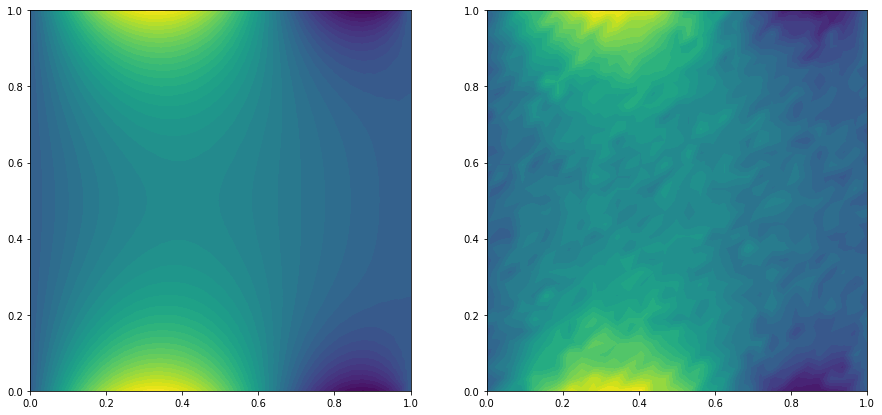

In [10]:

plt.figure(figsize=(15,10))

plt.subplot(121)
dl.plot(u)

plt.subplot(122)
dl.plot(u2)
